# Robust control H-Gate

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
from attr import asdict

from qctrl import Qctrl

# Starting a session with the API
qctrl = Qctrl(email = 'hassaanghazali@gmail.com', password = 'dabadee')


In [63]:
# Define standard matrices
identity = np.array([[1.0, 0.0], [0.0, 1.0]], dtype=np.complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=np.complex)
sigma_y = np.array([[0.0, -1j], [1j, 0.0]], dtype=np.complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=np.complex)
sigma_m = np.array([[0.0, 1.0], [0.0, 0.0]], dtype=np.complex)
sigmas = [sigma_x, sigma_y, sigma_z]
sigma_names = ["X", "Y", "Z"]
h_gate = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
# Plotting and formatting methods
plt.style.use(qv.get_qctrl_style())


def plot_simulation_trajectories(figure, times, coherent_samples, noisy_trajectories):
    ideal_bloch_sphere_coords = np.array(
        [
            [
                np.real(
                    np.dot(
                        sample.state_vector.conj(),
                        np.matmul(sigma, sample.state_vector),
                    )
                )
                for sigma in sigmas
            ]
            for sample in coherent_samples
        ]
    )
    noisy_bloch_sphere_coords = np.array(
        [
            [
                [
                    np.real(
                        np.dot(
                            sample.state_vector.conj(),
                            np.matmul(sigma, sample.state_vector),
                        )
                    )
                    for sigma in sigmas
                ]
                for sample in trajectory.samples
            ]
            for trajectory in noisy_trajectories
        ]
    )
    figure.set_figheight(6.0)
    figure.set_figwidth(7.0)
    axes = figure.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=False)[
        :, 0
    ]
    for a in range(3):
        axes[a].set_ylabel(sigma_names[a])
        axes[a].set_ylim([-1.1, 1.1])
        for t in range(noisy_bloch_sphere_coords.shape[0]):
            axes[a].plot(
                times * 1e6,
                noisy_bloch_sphere_coords[t, :, a],
                "--",
                color="#680CE9",
                alpha=0.25,
            )
        axes[a].plot(times * 1e6, ideal_bloch_sphere_coords[:, a], "-", color="#680CE9")
    axes[2].set_xlabel("Time ($\mu$s)")
    axes[0].set_title("Bloch sphere coordinates")


def plot_simulation_noise_directions(figure, times, coherent_samples):
    figure.set_figheight(6.0)
    figure.set_figwidth(7.0)
    noise_operator_directions = np.array(
        [
            [
                0.5
                * np.real(
                    np.trace(
                        np.matmul(
                            sigma,
                            np.matmul(
                                sample.evolution_operator.conj().T,
                                np.matmul(sigma_z, sample.evolution_operator),
                            ),
                        )
                    )
                )
                for sigma in sigmas
            ]
            for sample in coherent_samples
        ]
    )
    axes = figure.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=False)[
        :, 0
    ]
    for a in range(3):
        axes[a].set_ylabel(sigma_names[a])
        axes[a].set_ylim([-1.1, 1.1])
        axes[a].plot(
            robust_point_times * 1e6,
            noise_operator_directions[:, a],
            "-",
            color="#680CE9",
        )
        axes[a].fill_between(
            robust_point_times * 1e6,
            0,
            noise_operator_directions[:, a],
            color="#680CE9",
            alpha=0.25,
        )
    axes[2].set_xlabel("Time ($\mu$s)")
    axes[0].set_title("Bloch sphere directions")


def plot_noise_spectral_density(figure, nsd_samples):
    frequencies = np.array([sample["frequency"] for sample in nsd_samples])
    powers = np.array([sample["power"] for sample in nsd_samples])
    axes = figure.subplots(nrows=1, ncols=1, sharex=True, sharey=False, squeeze=False)[
        0, 0
    ]
    axes.plot(frequencies / 1e6, powers * 1e6)
    axes.fill_between(frequencies / 1e6, 0, powers * 1e6, alpha=0.25)
    axes.set_xlabel("Frequency (MHz)")
    axes.set_ylabel("Power density (1/MHz)")
    axes.set_title("Dephasing noise spectral density")


def pm_format(average, std):
    return "{:.4f}".format(average) + "+/-" + "{:.4f}".format(std)


def bandwidth_limited_pwc_signal(
    name, duration, segment_count, max_rabi_rate, cutoff_frequency
):

    # create a raw pwc_signal where the amplitude of each segment is an optimization variables
    raw_signal = qctrl.operations.pwc_signal(
        values=qctrl.operations.bounded_optimization_variable(
            count=segment_count, lower_bound=-max_rabi_rate, upper_bound=max_rabi_rate
        ),
        duration=duration,
    )

    # pass the signal through a bandwidth limited filter
    filtered_signal = qctrl.operations.convolve_pwc(
        raw_signal, qctrl.operations.sinc_integral_function(cutoff_frequency)
    )

    # resample the smooth filtered signal as a pwc_signal
    final_signal = qctrl.operations.discretize_stf(
        stf=filtered_signal,
        duration=robust_duration,
        segments_count=segment_count,
        name=name,
    )

    return final_signal


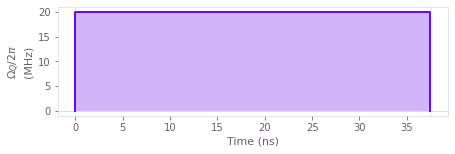

In [64]:
omega_max = 40 * np.pi *1e6  # Hz

standard_duration = 3* np.pi / (2 * omega_max )  # ms

standard_pulse_segments = [
    qctrl.types.ComplexSegmentInput(duration=standard_duration, value=omega_max),
]

plot_segments = {
    "$\Omega_Q$": [
        {"duration": segment.duration, "value": segment.value}
        for segment in standard_pulse_segments
    ]
}

qv.plot_controls(plt.figure(), plot_segments)
plt.show()


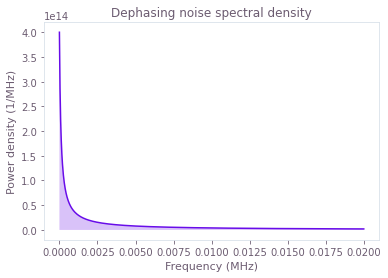

In [65]:
def power_spectrum(frequencies, frequency_cutoff, power):
    return frequency_cutoff ** (power - 1) / (
        frequencies ** power + frequency_cutoff ** power
    )


frequencies = np.linspace(0, 2.0e4, 1000)
power_densities = 4e10 * power_spectrum(frequencies, 1.0e2, 1.0)
nsd_sampled_points = [
    {"frequency": f, "power": p, "power_uncertainty": 0.0, "weight": 0.0}
    for f, p in zip(frequencies, power_densities)
]

plot_noise_spectral_density(plt.figure(), nsd_sampled_points)


In [66]:
standard_control = qctrl.types.colored_noise_simulation.Shift(
    control=standard_pulse_segments, operator=sigma_y / 2.0
)

noise_drift = qctrl.types.colored_noise_simulation.Drift(
    operator=sigma_z / 4.0,
    noise=qctrl.types.colored_noise_simulation.Noise(
        power_densities=power_densities,
        frequency_step=frequencies[1],
        time_domain_sample_count=1000,
    ),
)

target = qctrl.types.TargetInput(operator=h_gate)


In [67]:
standard_point_times = np.linspace(0, standard_duration, 100)

standard_noisy_simulation_result = qctrl.functions.calculate_colored_noise_simulation(
    duration=standard_duration,
    sample_times=standard_point_times,
    shifts=[standard_control],
    drifts=[noise_drift],
    trajectory_count=5,
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_colored_noise_simulation has started.
Your task calculate_colored_noise_simulation has completed in 8s.


In [68]:
standard_ideal_simulation_result = qctrl.functions.calculate_coherent_simulation(
    duration=standard_duration,
    sample_times=standard_point_times,
    shifts=[standard_control],
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_coherent_simulation has completed in 4s.


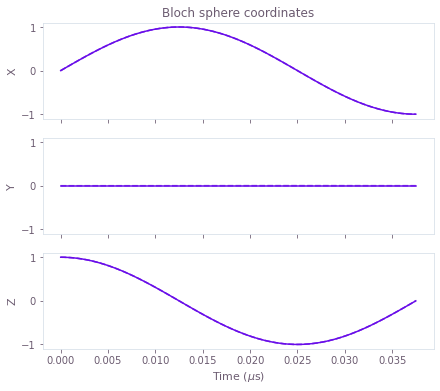

In [69]:
plot_simulation_trajectories(
    plt.figure(),
    standard_point_times,
    standard_ideal_simulation_result.samples,
    standard_noisy_simulation_result.trajectories,
)
plt.show()


In [70]:
standard_final_sample = standard_noisy_simulation_result.average_samples[-1]
print("Average gate infidelity:")
print(
    pm_format(
        standard_final_sample.average_infidelity,
        standard_final_sample.average_infidelity_uncertainty,
    )
)

Average gate infidelity:
1.0000+/-0.0000


In [71]:
sample_count = 3000
interpolated_frequencies = omega_max * np.logspace(-8, 1, 1000, base=10)

filter_noise_drift = qctrl.types.filter_function.Drift(
    noise=True, operator=sigma_z / 4.0
)

standard_filter_function_results = qctrl.functions.calculate_filter_function(
    duration=standard_duration,
    frequencies=interpolated_frequencies,
    sample_count=sample_count,
    shifts=[standard_control],
    drifts=[filter_noise_drift],
)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_filter_function has completed in 5s.


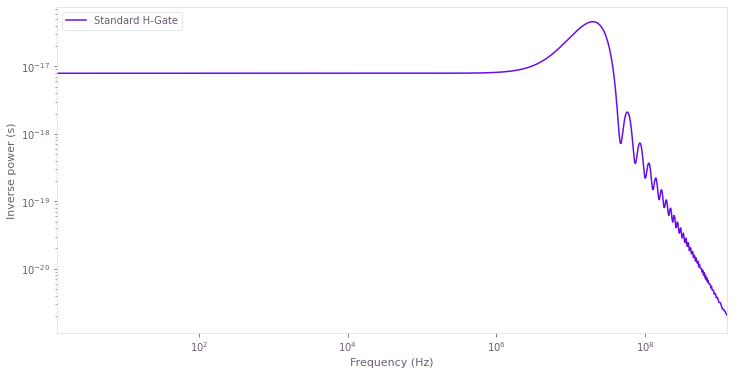

In [72]:
standard_filter_function_interpolated_points = [
    asdict(sample) for sample in standard_filter_function_results.samples
]

qv.plot_filter_functions(
    plt.figure(), {"Standard H-Gate": standard_filter_function_interpolated_points}
)
plt.show()


In [73]:
integral_max = 1e5

standard_frequencies = np.array(
    [
        sample.frequency
        for sample in standard_filter_function_results.samples
        if sample.frequency < integral_max
    ]
)
standard_inverse_powers = np.array(
    [
        sample.inverse_power
        for sample in standard_filter_function_results.samples
        if sample.frequency < integral_max
    ]
)
standard_filter_function_infidelity = np.trapz(
    y=standard_inverse_powers * 4e10 * power_spectrum(standard_frequencies, 1.0e2, 1.0),
    x=standard_frequencies,
)

print("Approximate filter function gate infidelity:")
print("{:4f}".format(standard_filter_function_infidelity))


Approximate filter function gate infidelity:
0.000002


In [74]:
robust_duration = 3.0 * standard_duration
omega_cutoff = 1e7
segment_count = 100

with qctrl.create_graph() as graph:

    # Omega_I(v,t)
    pulse_i = bandwidth_limited_pwc_signal(
        name="I",
        duration=robust_duration,
        segment_count=segment_count,
        max_rabi_rate=omega_max,
        cutoff_frequency=omega_cutoff,
    )

    # Omega_Q(v,t)
    pulse_q = bandwidth_limited_pwc_signal(
        name="Q",
        duration=robust_duration,
        segment_count=segment_count,
        max_rabi_rate=omega_max,
        cutoff_frequency=omega_cutoff,
    )

    # Omega_I(t) sigma_x/2
    robust_control_i = qctrl.operations.pwc_operator(
        signal=pulse_i, operator=sigma_x / 2.0
    )

    # Omega_Q(t) sigma_y/2
    robust_control_q = qctrl.operations.pwc_operator(
        signal=pulse_q, operator=sigma_y / 2.0
    )

    # H_control = Omega_I(t) sigma_x/2 + Omega_Q(t) sigma_y/2
    control_hamiltonian = qctrl.operations.pwc_sum([robust_control_i, robust_control_q])

    # sigma_z / 2w
    noise_operator = qctrl.operations.constant_pwc_operator(
        robust_duration, sigma_z / 4.0 / robust_duration
    )

    # create U_target
    target_unitary = qctrl.operations.target(operator=h_gate)

    # create I_robust(v) = I_control(v) + I_noise(v)
    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=control_hamiltonian,
        noise_operators=[
            noise_operator,
        ],
        target_operator=target_unitary,
        name="infidelity",
    )


In [75]:
optimization_result = qctrl.functions.calculate_optimization(
    cost_node_name="infidelity",
    output_node_names=["infidelity", "I", "Q"],
    graph=graph,
)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 22s.


In [76]:
print("Best cost:")
print(optimization_result.cost)


Best cost:
0.4710427558265981


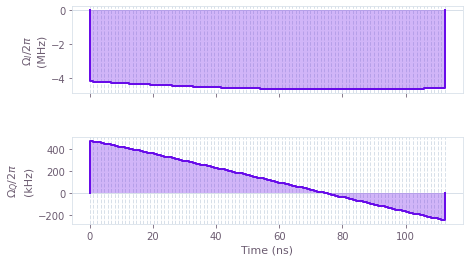

In [77]:
qv.plot_controls(
    plt.figure(),
    {
        "$\Omega_I$": optimization_result.output["I"],
        "$\Omega_Q$": optimization_result.output["Q"],
    },
)
plt.show()


In [78]:
robust_pulse_segments_i = [
    qctrl.types.RealSegmentInput(duration=segment["duration"], value=segment["value"])
    for segment in optimization_result.output["I"]
]

robust_pulse_segments_q = [
    qctrl.types.RealSegmentInput(duration=segment["duration"], value=segment["value"])
    for segment in optimization_result.output["Q"]
]

robust_control_i = qctrl.types.colored_noise_simulation.Shift(
    control=robust_pulse_segments_i, operator=sigma_x / 2.0
)

robust_control_q = qctrl.types.colored_noise_simulation.Shift(
    control=robust_pulse_segments_q, operator=sigma_y / 2.0
)

sample_count = 3000
interpolated_frequencies = omega_max * np.logspace(-8, 1, 1000, base=10)

robust_filter_function_results = qctrl.functions.calculate_filter_function(
    duration=robust_duration,
    frequencies=interpolated_frequencies,
    sample_count=sample_count,
    shifts=[robust_control_i, robust_control_q],
    drifts=[filter_noise_drift],
)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_filter_function has started.
Your task calculate_filter_function has completed in 8s.


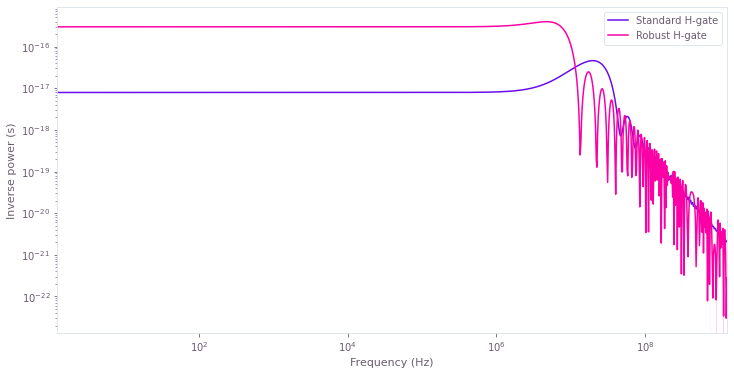

In [79]:
robust_filter_function_interpolated_points = [
    asdict(sample) for sample in robust_filter_function_results.samples
]

qv.plot_filter_functions(
    plt.figure(),
    {
        "Standard H-gate": standard_filter_function_interpolated_points,
        "Robust H-gate": robust_filter_function_interpolated_points,
    },
)
plt.show()


In [80]:
robust_frequencies = np.array(
    [
        sample.frequency
        for sample in robust_filter_function_results.samples
        if sample.frequency < integral_max
    ]
)
robust_inverse_powers = np.array(
    [
        sample.inverse_power
        for sample in robust_filter_function_results.samples
        if sample.frequency < integral_max
    ]
)
robust_filter_function_infidelity = np.trapz(
    y=robust_inverse_powers * 4e10 * power_spectrum(robust_frequencies, 1.0e2, 1.0),
    x=robust_frequencies,
)

print("Approximate filter function standard gate infidelity:")
print("{:4f}".format(standard_filter_function_infidelity))

print("Approximate filter function robust gate infidelity:")
print("{:4f}".format(robust_filter_function_infidelity))


Approximate filter function standard gate infidelity:
0.000002
Approximate filter function robust gate infidelity:
0.000082


In [81]:
robust_point_times = np.linspace(0, robust_duration, 100)

robust_noisy_simulation_result = qctrl.functions.calculate_colored_noise_simulation(
    duration=robust_duration,
    sample_times=robust_point_times,
    shifts=[robust_control_i, robust_control_q],
    drifts=[noise_drift],
    trajectory_count=10,
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_colored_noise_simulation has started.
Your task calculate_colored_noise_simulation has completed in 25s.


In [82]:
robust_ideal_simulation_result = qctrl.functions.calculate_coherent_simulation(
    duration=robust_duration,
    sample_times=robust_point_times,
    shifts=[robust_control_i, robust_control_q],
    initial_state_vector=np.array([1.0, 0.0]),
    target=target,
)


  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_coherent_simulation has completed in 4s.


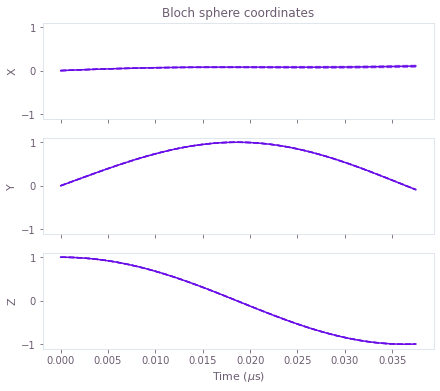

In [83]:
plot_simulation_trajectories(
    plt.figure(),
    standard_point_times,
    robust_ideal_simulation_result.samples,
    robust_noisy_simulation_result.trajectories,
)
plt.show()


In [84]:
robust_final_sample = robust_noisy_simulation_result.average_samples[-1]

print("Average gate infidelity:")

print("Average standard gate infidelity:")
print(
    pm_format(
        standard_final_sample.average_infidelity,
        standard_final_sample.average_infidelity_uncertainty,
    )
)

print("Average robust gate infidelity:")
print(
    pm_format(
        robust_final_sample.average_infidelity,
        robust_final_sample.average_infidelity_uncertainty,
    )
)


Average gate infidelity:
Average standard gate infidelity:
1.0000+/-0.0000
Average robust gate infidelity:
0.4492+/-0.0022


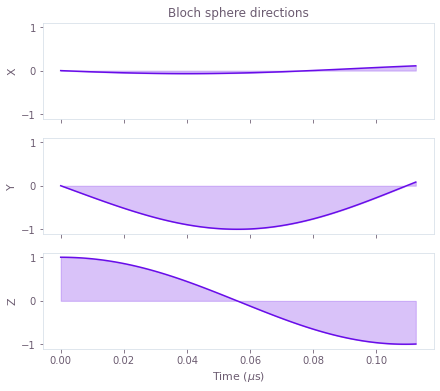

In [85]:
coherent_frames = robust_ideal_simulation_result.samples

figure = plt.figure()
plot_simulation_noise_directions(figure, robust_point_times, coherent_frames)
plt.show()